In [45]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)
import tqdm

Sigmoid neurons

In [46]:
d = 100 # dimension of space
M = 20 # number of neurons for generation

In [47]:
def sigma(x):
    return (1. / (1. + np.exp(-x)))

In [48]:
class Neuron:
    def __init__(self):
        self.a = np.random.normal(loc = 2., scale = 10.)
        self.w = np.random.normal(size = d)
        self.b = np.random.normal()
    def set_weights(self, a, w, b):
        self.a = a
        self.w = w
        self.b = b
    def forward(self, x):
        return self.a * sigma(self.w.dot(x) + self.b)

In [49]:
class Network:
    def __init__(self, width):
        self.width = width
        self.neurons = [Neuron() for i in range(width)]
    def zero_out(self):
        for nr in self.neurons:
            nr.set_weights(0., nr.w, nr.b)
    def zero_bias(self):
        for nr in self.neurons:
            nr.set_weights(nr.a, nr.w, 0)
    def output(self, x):
        return np.mean([n.forward(x) for n in self.neurons])
    def loss(self, x, y):
        return .5*(self.output(x) - y)**2
    def grad(self, x, y):
        d = (self.output(x) - y)
        s = np.array([sigma(n.w.dot(x) + n.b) for n in self.neurons])
        ga = 1./self.width * d * s
        gb = 1./self.width * d * np.array([self.neurons[i].a*s[i]*(1-s[i]) for i in range(self.width)])
        gw = np.array([gb[i] * x for i in range(self.width)]) # shape m * d
        return ga, gw, gb
    def step(self, x, y, tau):
        ga, gw, gb = self.grad(x, y)
        for i in range(self.width):
            nr = self.neurons[i]
            a_new = nr.a - tau * ga[i]
            w_new = nr.w - tau * gw[i]
            b_new = nr.b - tau * gb[i]
            nr.set_weights(a_new, w_new, b_new)
    def batch_step(self, X, Y, tau):
        ba = X.shape[0]
        Ga, Gw, Gb = np.zeros((ba, self.width)), np.zeros((ba, self.width, d)), np.zeros((ba, self.width))
        for i in range(ba):
            Ga[i], Gw[i], Gb[i] = self.grad(X[i], Y[i])
        ga, gw, gb = Ga.sum(axis = 0), Gw.sum(axis = 0), Gb.sum(axis = 0)
        for i in range(self.width):
            nr = self.neurons[i]
            a_new = nr.a - tau * ga[i]
            w_new = nr.w - tau * gw[i]
            b_new = nr.b - tau * gb[i]
            nr.set_weights(a_new, w_new, b_new)
    def sgd_train(self, X, Y, tau, epochs, batch, disp = True):
        for e in range(epochs):
            pm = np.random.permutation(X.shape[0])
            X = np.array([X[pm[i]] for i in range(X.shape[0])])
            Y = np.array([Y[pm[i]] for i in range(Y.shape[0])])
            if batch > 1:
                nbatch = X.shape[0]//batch
                subX = np.split(X, nbatch)
                subY = np.split(Y, nbatch)
                for s in range(len(subX)):
                    self.batch_step(subX[s], subY[s], tau)
            else:
                for i in range(X.shape[0]):
                    self.step(X[i], Y[i], tau)
            loss = self.test(X, Y)
            if disp:
                print('epoch '+str(e)+' : '+str(loss))
        return loss
    def test(self, X_t, Y_t):
        ts = X_t.shape[0]
        return np.mean([self.loss(X_t[i], Y_t[i]) for i in range(ts)])
    def gen_sample(self, R, s = 1):
        if s==1:
            X = np.random.normal(size = d)
            # see one which one it should be
            #X = R * X / np.linalg.norm(X, 2)
            X = R * X / np.sqrt(1. + np.linalg.norm(X, 2)**2)
            Y = self.output(X)
            return X, Y
        else:
            X = np.random.normal(size = (s, d))
            Y = np.zeros(s)
            for i in range(s):
                # see one which one it should be
                X[i] = R * X[i] / np.sqrt(1. + np.linalg.norm(X[i], 2)**2)
                #X[i] = R* X[i] / np.linalg.norm(X[i], 2)
                Y[i] = self.output(X[i])
            return X, Y
    def give_weights(self):
        la, lw, lb = np.zeros(self.width), np.zeros((self.width, d)), np.zeros(self.width)
        for i in range(self.width):
            nr = self.neurons[i]
            la[i] = nr.a
            lw[i] = nr.w
            lb[i] = nr.b
        return la, lw, lb
    def display_weights(self, fig, ax, scatp = None, scatn = None, true_w = None, color='b'):
        assert d==2, 'must be in dimension 2'
        #ax.cla()
        ax.set_xlim((-3, 3))
        ax.set_ylim((-3, 3))
        la, lw, _ = self.give_weights()
        xp, yp, sp, xn, yn, sn = [],[],[],[],[],[]
        la = la / np.linalg.norm(la, 2)
        for k in range(self.width):
            if la[k] >=0:
                xp.append(lw[k, 0])
                yp.append(lw[k, 1])
                sp.append(500 * la[k])
            else:
                xn.append(lw[k, 0])
                yn.append(lw[k, 1])
                sn.append(-500 * la[k])
                
        if scatp is None:
            pos = ax.scatter(xp, yp, s = sp, color='r')
        else:
            scatp.set_sizes(30*sp)
            scatp.set_offsets(np.array([xp, yp]).T)
            trace = ax.scatter(xp, yp, s = 5., color='grey', alpha = 0.4)
            
        if scatn is None:
            neg = ax.scatter(xn, yn, s = sn, color='b')
        else:
            scatn.set_sizes(30*sn)
            scatn.set_offsets(np.array([xn, yn]).T)
            trace = ax.scatter(xn, yn, s = 5., color='grey', alpha = 0.4)
        
        if true_w is not None:
            tla, tlw, _ = true_w
            tx, ty = np.zeros(tla.shape[0]), np.zeros(tla.shape[0])
            for k in range(tla.shape[0]):
                tx[k] = tlw[k, 0]
                ty[k] = tlw[k, 1]
                u = np.linspace(-3, 3., 10)
                v = ty[k]/tx[k] * u
                ax.plot(u, v, color = 'k')
        
        if scatp is None and scatn is None:
            fig.canvas.draw()
        #del pos
        #del neg
        return xp, yp, xn, yn

In [ ]:
#fig, ax = plt.subplots(figsize=(10, 6))

gen_net = Network(M)

true_w = gen_net.give_weights()
print(true_w)
#xp, yp, xn, yn = gen_net.display_weights(fig, ax, color='g', true_w = true_w)
#ax.scatter(xp, yp, s = 10., color='r')
#ax.scatter(xn, yn, s = 10., color='b')

Initialize new network with first parameter 0 and others normal.

In [98]:
net = Network(50)
net.zero_out()

Data on the sphere

In [99]:
#X, Y = gen_net.gen_sample(R = 10, s = 10000)

Train it using SGD

In [100]:
for i in range(100):
    X, Y = gen_net.gen_sample(R = 10., s = 1000)
    net.sgd_train(X, Y, tau = .1, batch = 4, epochs = 1, disp = True)

epoch 0 : 0.79204976997879
epoch 0 : 0.7083960174584295
epoch 0 : 0.7070588502897689
epoch 0 : 0.7668215772777983
epoch 0 : 0.7114081540182945
epoch 0 : 0.6667247240713939
epoch 0 : 0.6798534145268419
epoch 0 : 0.6667991424815793
epoch 0 : 0.6234455843449598
epoch 0 : 0.6749723453658824
epoch 0 : 0.588264371529535
epoch 0 : 0.5899467546988877
epoch 0 : 0.6341572348165214
epoch 0 : 0.5683457711340724
epoch 0 : 0.5325604839768537
epoch 0 : 0.5884197985618762
epoch 0 : 0.4927789857162444
epoch 0 : 0.5360539528419078
epoch 0 : 0.506358988988432
epoch 0 : 0.5099317045605976
epoch 0 : 0.4387700149143451
epoch 0 : 0.44206499377046315
epoch 0 : 0.45881971552249684
epoch 0 : 0.41535355478753205
epoch 0 : 0.42231640093930717
epoch 0 : 0.4060663535035882
epoch 0 : 0.36169891834768336
epoch 0 : 0.3311885188146192
epoch 0 : 0.3227942187441779
epoch 0 : 0.33022923350203276
epoch 0 : 0.29714195026968554
epoch 0 : 0.29905589440143593
epoch 0 : 0.27056487142225044
epoch 0 : 0.24781019254913786
epoch 0 

In [101]:
net = Network(10)
net.zero_out()

for i in range(100):
    X, Y = gen_net.gen_sample(R = 10., s = 10000)
    net.sgd_train(X, Y, tau = .1, batch = 4, epochs = 1, disp = True)

epoch 0 : 0.2946000476733624
epoch 0 : 0.21888410379205062
epoch 0 : 0.20717455252193795
epoch 0 : 0.19418069798802717
epoch 0 : 0.19108213901378293
epoch 0 : 0.18399723311402694
epoch 0 : 0.1839201342092475
epoch 0 : 0.1741652540678053
epoch 0 : 0.16131460084783047
epoch 0 : 0.14799494239884434
epoch 0 : 0.13846846010932512
epoch 0 : 0.12451600062325617
epoch 0 : 0.11247170000479648
epoch 0 : 0.09654327276835743
epoch 0 : 0.08736709266488922
epoch 0 : 0.08193634191537405
epoch 0 : 0.0802291236856312
epoch 0 : 0.07865950169046673
epoch 0 : 0.07859462371040184
epoch 0 : 0.07617987876401634
epoch 0 : 0.07446867291473232
epoch 0 : 0.07387059912932337
epoch 0 : 0.06776263711070873
epoch 0 : 0.06498209232201442
epoch 0 : 0.06286818761482559
epoch 0 : 0.0587772461650899
epoch 0 : 0.05919155963662697
epoch 0 : 0.05779283418798652
epoch 0 : 0.052864748756553205
epoch 0 : 0.050680488229375785
epoch 0 : 0.04844659409828491
epoch 0 : 0.04781260446906322
epoch 0 : 0.048166869222636265
epoch 0 : 0.

We DO NOT reproduce the results :(

## Make several experiments for different values of $m$

In [58]:
np.logspace(0.6, 2.0, 15, base = 10.)

array([  3.98107171,   5.01187234,   6.30957344,   7.94328235,
        10.        ,  12.58925412,  15.84893192,  19.95262315,
        25.11886432,  31.6227766 ,  39.81071706,  50.11872336,
        63.09573445,  79.43282347, 100.        ])

Early stopping if no improvement for k rounds -> def train_to_opt to ensure convergence

In [59]:
m_range = np.logspace(0.6, 2.0, 15, base = 10.)
m_range = [int(b) for b in m_range]
rep = 1
losses = np.zeros((len(m_range), rep))

for r in tqdm.tqdm(range(rep)):
    gen_net = Network(M)
    Xt, Yt = gen_net.gen_sample(R = 100, s = 1000)
    for mi in range(len(m_range)):
        m = m_range[mi]
        net = Network(m)
        net.zero_out()
        X, Y = gen_net.gen_sample(R = 100, s = 20000)
        train_loss = net.sgd_train(X, Y, tau = .1, batch = 10, epochs = 1, disp = False)
        print('train', train_loss)
        losses[mi, r] = net.test(Xt, Yt)
        print('test', losses[mi, r])
        net = []
        print(m)

  0%|          | 0/1 [00:00<?, ?it/s]/Users/eloise/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


train 0.5448082682755575
test 0.573764869060813
3
train 0.4159811036691315
test 0.42562705816780616
5
train 0.3772323259362697
test 0.3758681223979035
6
train 0.38742523282868346
test 0.3914055439572904
7
train 0.3540283534045254
test 0.3525521849293182
10
train 0.35981151617269685
test 0.34475628457191554
12
train 0.32850182861131016
test 0.3438091168855692
15
train 0.3445246714038056
test 0.35887320670377143
19
train 0.36146070611355446
test 0.3719601751977567
25
train 0.46714332155731925
test 0.4816220640744987
31
train 0.49599529008203863
test 0.5308167858131756
39


KeyboardInterrupt: 

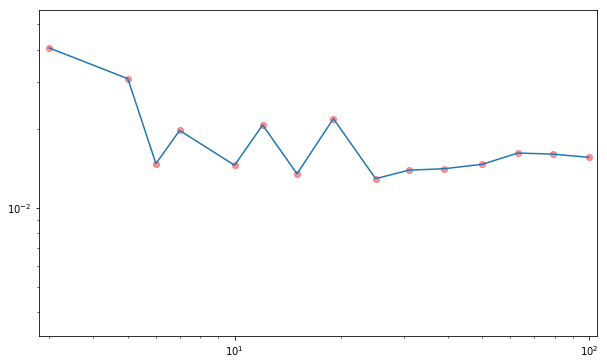

In [44]:
plt.figure(figsize = (10, 6))
for i in range(rep):
    plt.scatter(m_range, losses[:, i], c='r', alpha = 0.4)
plt.plot(m_range, np.exp(np.mean(np.log(losses), axis = 1)))
plt.yscale('log')
plt.xscale('log')
plt.xlim((2.8, 105))
#plt.ylim((1e-6, 1))
plt.show()

Write batch train function, reduce d, "use fresh samples at each iteration", sampling at test time